In [1]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt



Current data is shaped: (1250, 100, 514)


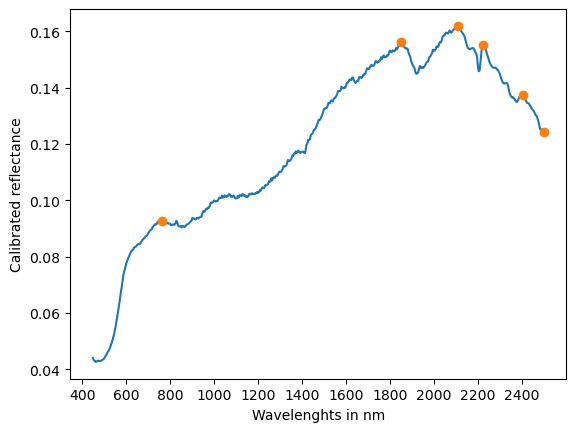

In [2]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 490
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

In [61]:
# Master peak ranges
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']

peaks_of_interest = []
peaks_of_interest_wl = []
peaks_of_interest_min = []
peaks_of_interest_max = []
peaks_of_interest_label = []

for peak in peaks:
# peak = peaks[0]
    curr_wav = wav_array[peak]
    # print(f"Checking {curr_wav}")
    for i, k in enumerate(min_list):
        k = min_list[i]
        kmax = max_list[i]
        
        if curr_wav >= k and curr_wav <= kmax:
            # print(mineral_label[i])
            peaks_of_interest.append(peak)
            peaks_of_interest_min.append(k)
            peaks_of_interest_max.append(kmax)
            peaks_of_interest_label.append(mineral_label[i])
            peaks_of_interest_wl.append(wav_array[peak])

print(peaks_of_interest)
print(peaks_of_interest_wl)
print(peaks_of_interest_min)
print(peaks_of_interest_max)
print(peaks_of_interest_label)

[444, 444, 489, 513]
[2224.0, 2224.0, 2404.0, 2500.0]
[2185, 2220, 2375, 2490]
[2230, 2265, 2415, 2550]
['pyrophyllite', 'Al-OH', 'tourmaline', 'amphiboles, biotite']


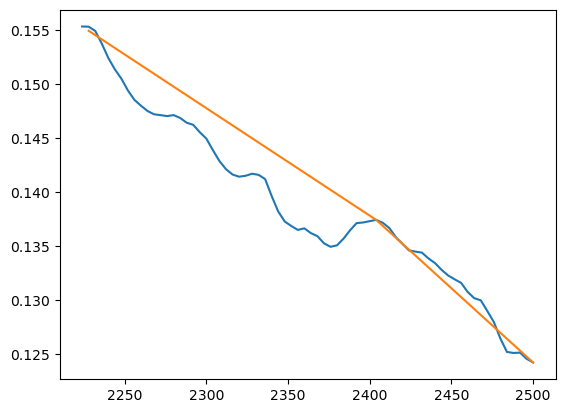

In [72]:
# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


hull_subset = interpolate_linear(curr_pixel[peaks_of_interest[0]:],
                                     peaks_of_interest - peaks_of_interest[0])

plt.plot(wav_array[peaks_of_interest[0]:],
         curr_pixel[peaks_of_interest[0]:])

plt.plot(wav_array[peaks_of_interest[0]:],
         hull_subset) 